# Setup

Here we provide a Monte Carlo simulation to assess a distribution of errors in a sharded system. System's behavior is set to model pessimistic scenario of error propagation.

## Assumptions:
- For simplicity, we keep track only of invalid messages.
- Messages have a fixed size $1$.
- The first shard starts with $N_{\text{invalid}}$ invalid outgoing messages to random most active accounts.
- Messages propagate via a hypercube routing mechanism.
- Each account that receives an invalid message becomes an invalid (corrupted) account. A shard with a corrupted account is considered invalid.
- Each invalid account has a probability $p$ to send an invalid message to a "random" account.
- At each step we also keep track of the number of "router" shards, i.e., shards that don't have any invalid accounts, but routed invalid messages.

## Simulation dynamics:
- Initialization: add $N$ invalid messages to the first shard's incoming messages. Messages are sent to random accounts.
- At each step:
    - For each shard in the systems:
        - Route and deliver incoming messages
        - Create new messages
    - Collect mertics


## Simulation parameters:
- Number of shards $N_{\text{shards}}$, by default $N_{\text{shards}} = 2^{10}$.
- Block size $B$, for simplicity we assume that  each message has  by default $B = 200$.
- Number of invalid messages in the first shard $N_{\text{invalid}}$, by default $N_{\text{invalid}} = 100$.
- Activity of an account $-$ average number of messages sent per step. For each new invalid account we track we sample the activity from the Ethereum's distribution of account activity.
- Average path length $L$ in the hypercube routing, by default $L = \frac{\log_2(N_{\text{shards}})}{2}$.


## Metrics:
- Each shard has either valid or invalid state. So ratio of invalid shards is the natural metric here.
- Nevertheless, we can also track the number of "router" shards, i.e., shards that don't have any invalid accounts, but routed invalid messages.
- To assess the speed of error propagation, we track the number of steps until half of the shards become invalid.

## Some results:
- Initially the number of invalid shards grows exponentially with the number of steps.
- Time to corrupt half of the system is highly dependent on the average path length $L$. For small $L$ the system becomes quite inert to errors, since communication is mostly local.


## Further improvements and corrections:
- The model doesn't take into account connectivity structure of the real world networks: right now it has only the same degree distribution. The estimates can be improved by using more realistic network models, since active accounts are more likely to communicate with outher active accounts and form clusters. But for the pessimistic scenario it's not that important, since we want to model the most chaotic case.

# Simulation code

In [267]:
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [307]:
def func_powerlaw(x, m=-1.09506237e+00, c=7.23083266e+01, c0=1.14142051e-05):
    """Empirical powerlaw function fitted to the Ethereum internal transactions data"""
    return c0 + x**m * c

def get_random_activity(bias=False):
    if bias:
        sample_index = random.randint(1, 100)
    else:
        sample_index = random.randint(1, 1e6)
    return func_powerlaw(sample_index)


class Account:
    def __init__(self, id, activity=0):
        '''
        account is invalid if it has received an invalid message
        activity is the probability of sending a message
        '''
        self.id = id
        self.activity = activity

    def maybe_send_message(self):
        return random.random() < self.activity

    def get_num_msgs(self):
        return np.random.poisson(self.activity)


class Message:
    def __init__(self, source, destination):
        self.source = source
        self.destination = destination
    
    def __repr__(self) -> str:
        return f"msg {self.source} -> {self.destination}"


class Shard:
    def __init__(self, id):
        self.id = id
        self.routed_msgs_count = 0
        self.pool: list[Message] = []
        self.corrupted_accounts: dict[str, Account] = dict()

    def next_hop(self, dest_id: str):
        diff_ids = [i for i in range(len(self.id)) if self.id[i] != dest_id[i]]
        if diff_ids == []:
            return dest_id
        flip_idx = random.choice(diff_ids)
        return self.id[:flip_idx] + dest_id[flip_idx] + self.id[flip_idx+1:]

    def is_router(self):
        return self.routed_msgs_count > 0
    
    def is_corrupted(self):
        return len(self.corrupted_accounts) > 0 or self.is_router()


class Simulation:
    def __init__(self, n_shard_bits, n_account_bits,
                 num_initial_invalid_msgs=10,
                 avg_routing_length=10,
                 block_size=100):
        self.num_initial_invalid_msgs = num_initial_invalid_msgs
        self.n_shard_bits = n_shard_bits
        self.n_account_bits = n_account_bits
        self.shards: dict[str, Shard] = None
        self.avg_routing_length = avg_routing_length
        self.block_size = block_size

    def init(self):
        if self.shards is None:
            self.shards = {
                format(i, f'0{self.n_shard_bits}b'): Shard(format(i, f'0{self.n_shard_bits}b'))\
                    for i in range(2**self.n_shard_bits)}
        else:
            for shard in self.shards.values():
                shard.pool = []
                shard.routed_msgs_count = 0
                shard.corrupted_accounts = dict()
        for _ in range(self.num_initial_invalid_msgs):
            source = format(0, f'0{self.n_shard_bits}b') \
                + format(random.randint(0, 2**self.n_account_bits-1), f'0{self.n_account_bits}b')
            dest = format(random.randint(0, 2**self.n_shard_bits-1), f'0{self.n_shard_bits}b') \
                + format(random.randint(0, 2**self.n_account_bits-1), f'0{self.n_account_bits}b')
            shard_source = source[:self.n_shard_bits]

            msg = Message(source, dest)
            self.shards[shard_source].pool.append(msg)

    def run_step(self, step: int):
        for cur_shard_id, shard in self.shards.items():
            processed_tx_count = 0
            # deliver/route current messages
            while shard.pool and processed_tx_count < self.block_size:
                processed_tx_count += 1
                msg = shard.pool.pop()
                dest_shard_id = msg.destination[:self.n_shard_bits]
                if dest_shard_id == cur_shard_id:
                    if msg.destination in shard.corrupted_accounts:
                        continue
                    shard.corrupted_accounts[msg.destination] = Account(
                        id=msg.destination,
                        activity=get_random_activity(bias=step==0))
                else:
                    shard.routed_msgs_count += 1
                    next_shard_id = shard.next_hop(dest_shard_id)
                    self.shards[next_shard_id].pool.append(msg)
            # create new messages
            for acc in self.shards[cur_shard_id].corrupted_accounts.values():
                for _ in range(acc.get_num_msgs()):
                    dest_shard_id = cur_shard_id
                    bits_to_flip = random.sample(
                        range(self.n_shard_bits),
                        k=min(np.random.poisson(self.avg_routing_length), self.n_shard_bits))
                    for bit in bits_to_flip:
                        dest_shard_id = dest_shard_id[:bit] + str(1-int(dest_shard_id[bit])) + dest_shard_id[bit+1:]
                    dest = dest_shard_id \
                        + format(random.randint(0, 2**self.n_account_bits-1), f'0{self.n_account_bits}b')
                    msg = Message(acc.id, dest)
                    self.shards[cur_shard_id].pool.append(msg)

    def run(self, n_steps=20):
        self.init()
        router_ratios = []
        corrupted_ratios = []
        for step in range(n_steps):
            self.run_step(step)
            routers = [shard_id for shard_id, shard in self.shards.items() if shard.is_router()]
            corrupted_shards = [shard_id for shard_id, shard in self.shards.items() if shard.is_corrupted()]
            router_ratios.append(len(routers) / len(self.shards))
            corrupted_ratios.append(len(corrupted_shards) / len(self.shards))
        return {
            'router_ratios': router_ratios,
            'corrupted_ratios': corrupted_ratios,
        }

    def run_multiple(self, num_runs, num_steps):
        return [self.run(num_steps) for _ in tqdm(range(num_runs))]
    
    def num_steps_to_halt_half(self, num_runs):
        steps = []
        for _ in tqdm(range(num_runs), leave=False):
            self.init()
            step = 0
            while len([shard_id for shard_id, shard in self.shards.items() \
                       if shard.is_corrupted()]) < len(self.shards) // 2:
                self.run_step(step)
                step += 1
            steps.append(step)
        return steps


# Visualization

100%|██████████| 20/20 [00:00<00:00, 21.43it/s]


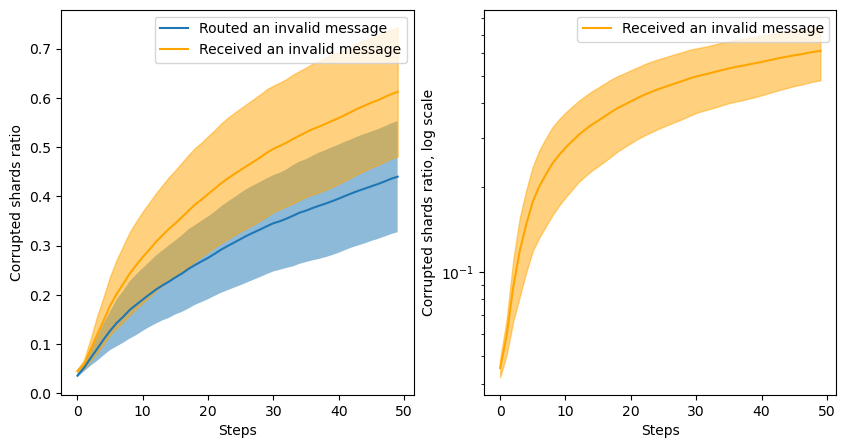

In [311]:
sim = Simulation(10, 118, num_initial_invalid_msgs=10, block_size=200, avg_routing_length=2)
results = sim.run_multiple(num_runs=20, num_steps=50)

router_ratios = np.array([res['router_ratios'] for res in results])
mean_router_ratios = np.mean(router_ratios, axis=0)
std_router_ratios = np.std(router_ratios, axis=0)

corrupted_ratios = np.array([res['corrupted_ratios'] for res in results])
mean_corrupted_ratios = np.mean(corrupted_ratios, axis=0)
std_corrupted_ratios = np.std(corrupted_ratios, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(mean_router_ratios, label='Routed an invalid message')
ax[0].fill_between(range(len(mean_router_ratios)),
                   mean_router_ratios-std_router_ratios,
                   mean_router_ratios+std_router_ratios,
                   alpha=0.5)
ax[0].plot(mean_corrupted_ratios, label='Received an invalid message', color='orange')
ax[0].fill_between(range(len(mean_corrupted_ratios)),
                   mean_corrupted_ratios-std_corrupted_ratios,
                   mean_corrupted_ratios+std_corrupted_ratios,
                   alpha=0.5,
                   color='orange')
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('Corrupted shards ratio')
ax[0].legend()

ax[1].plot(mean_corrupted_ratios, label='Received an invalid message', color='orange')
ax[1].fill_between(range(len(mean_corrupted_ratios)),
                   mean_corrupted_ratios-std_corrupted_ratios,
                   mean_corrupted_ratios+std_corrupted_ratios,
                   alpha=0.5,
                   color='orange')
ax[1].set_xlabel('Steps')
ax[1].set_ylabel('Corrupted shards ratio, log scale')
ax[1].set_yscale('log')
ax[1].legend()

plt.legend()
plt.show()

100%|██████████| 3/3 [00:21<00:00,  7.04s/it]


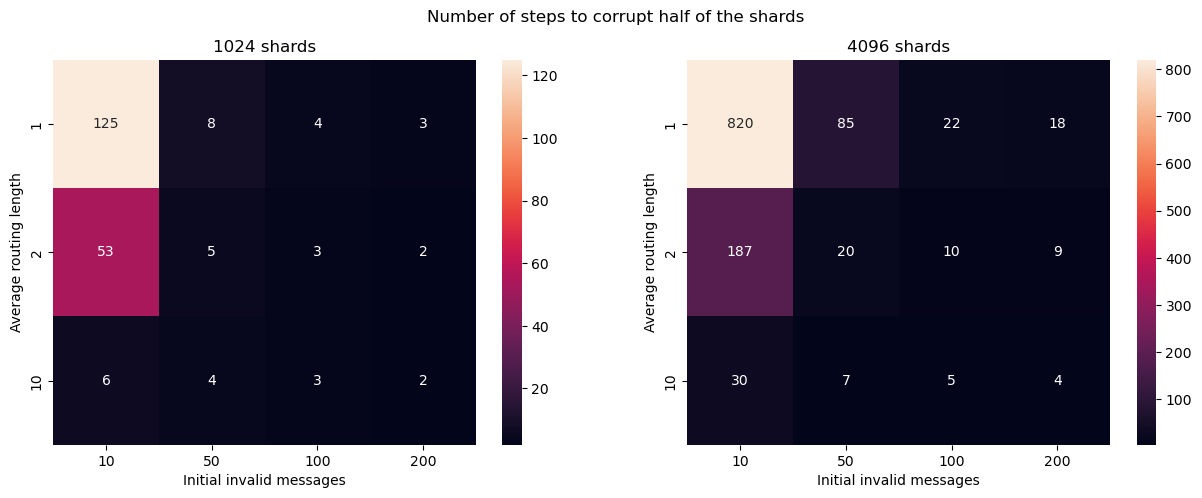

In [309]:
routing_lengths = np.array([1, 2, 10])
n_shard_bits_list = np.array([10, 12])
num_initial_invalid_msgs = np.array([10, 50, 100, 200])


results = {}
for avg_routing_length in tqdm(routing_lengths):
    for num_initial_invalid_msg in num_initial_invalid_msgs:
        for n_shard_bits in n_shard_bits_list:
            sim = Simulation(n_shard_bits, 118, num_initial_invalid_msgs=num_initial_invalid_msg, avg_routing_length=avg_routing_length)
            results[(n_shard_bits, num_initial_invalid_msg, avg_routing_length)] = sim.num_steps_to_halt_half(num_runs=3)


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Number of steps to corrupt half of the shards')

for i, n_shard_bits in enumerate(n_shard_bits_list):
    medians = np.array([[np.median(results[(n_shard_bits, num_initial_invalid_msg, avg_routing_length)]) \
                   for num_initial_invalid_msg in num_initial_invalid_msgs] for avg_routing_length in routing_lengths])
    sns.heatmap(medians, ax=ax[i], annot=True, fmt=".0f", xticklabels=num_initial_invalid_msgs, yticklabels=routing_lengths)
    ax[i].set_title(f"{2**n_shard_bits} shards")
    ax[i].set_xlabel('Initial invalid messages')
    ax[i].set_ylabel('Average routing length')